# Expectation Maximisation for Parameter Estimation of a Gaussian Mixture Model

In [522]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [523]:
# lets download the old faithful dataset from CMU website
# the data is avalable as .dat file
# and load it into a pandas dataframe
url = 'https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv'
# the dataset is tab separated
df = pd.read_csv(url, sep='\t')
df.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


In [524]:
# lets normalize the data

df = (df - df.mean()) / df.std()



In [525]:
class EM:
    def __init__(self):
        self.MuList = None
        self.SigmaList = None
        self.PiList = None
        self.K = None
        self.data = None
        self.maxIter = None
        self.threshold = None
        self.iter = None
        self.logLikelihood = None
        self.iterationData = {'MuList' : [], 'SigmaList' : [], 'PiList' : [], 'logLikelihood' : []}

        
    def gaussian_pdf(self, X, Mu, Sigma):
        """
        Calculates the probability density function of a multivariate Gaussian distribution.
        :param X: Data point
        :param Mu: Mean
        :param Sigma: Covariance matrix
        :return: Probability density function
        """
        return (2 * math.pi) ** (-X.shape[0] / 2) * (np.linalg.det(Sigma) ** -0.5) * np.exp(-0.5 * np.dot(np.dot((X - Mu), np.linalg.inv(Sigma)), (X - Mu).T))

    


    def fit(self, X, K, maxIter=100, threshold=1e-5):
        # define initial parameters
        self.K = K
        self.data = X
        self.maxIter = maxIter
        self.threshold = threshold
        self.iter = 0
        self.logLikelihood = []
        # initialize parameters
        # self.MuList = np.array([np.random.rand(self.data.shape[1]) for i in range(self.K)])
        self.MuList = np.array([[-2,-2],[2,2]])
        self.SigmaList = np.random.rand(self.K, X.shape[1], X.shape[1])
        self.PiList = np.random.rand(self.K)
        self.PiList = self.PiList / np.sum(self.PiList)
        
        # initalise sigma to Is
        for i in range(self.K):
            self.SigmaList[i] = np.identity(X.shape[1])
        
        # run EM algorithm
        while self.iter < self.maxIter:
            print(":",end="")
            self.iter += 1
            
            # update Mus
            for k in range(self.K):
                self.MuList[k] = self.update_mu_k(k)
            # update Sigmas
            for k in range(self.K):
                self.SigmaList[k] = self.update_sigma_k(k)
            # update Pis
            for k in range(self.K):
                self.PiList[k] = self.update_pi_k(k)
            # update log likelihood
            self.logLikelihood.append(self.calculate_log_likelihood())
            
            self.iterationData['MuList'].append(self.MuList)
            self.iterationData['SigmaList'].append(self.SigmaList)
            self.iterationData['PiList'].append(self.PiList)
            self.iterationData['logLikelihood'].append(self.logLikelihood[-1])
            # check convergence
            if self.iter > 1:
                if np.abs(self.logLikelihood[-1] - self.logLikelihood[-2]) < self.threshold:
                    break
    
        
    def update_mu_k(self, k):
        """
        Updates the mean of the kth Gaussian distribution.
        :param k: Index of the Gaussian distribution
        :return: Updated mean
        """
        new_mu = np.zeros(self.data.shape[1])
        for i in range(self.data.shape[0]):
            new_mu += self.gamma_nk(i, k) * self.data[i]
        new_mu /= self.N_k(k)
        return new_mu

    def update_sigma_k(self, k):
        new_sigma = np.zeros((self.data.shape[1], self.data.shape[1]))
        for i in range(self.data.shape[0]):
            gamma = self.gamma_nk(i, k)
            x = self.data[i]
            new_sigma += gamma * np.outer((x - self.MuList[k]), (x - self.MuList[k]))
            assert new_sigma[0][1] == new_sigma[1][0]
        new_sigma /= self.N_k(k)
        return new_sigma

    def update_pi_k(self, k):
        return self.N_k(k) / self.data.shape[0]

    
    def gamma_nk(self, n, k):
        """
        Calculates the posterior probability of the nth data point belonging to the kth Gaussian distribution.
        :param n: Index of the data point
        :param k: Index of the Gaussian distribution
        :return: Posterior probability
        """
        numerator = self.PiList[k] * self.gaussian_pdf(self.data[n], self.MuList[k], self.SigmaList[k])
        denominator = np.sum (np.array([self.PiList[i] * self.gaussian_pdf(self.data[n], self.MuList[i], self.SigmaList[i]) for i in range(self.K)]))
        return numerator / denominator

    def N_k(self, k):
        """
        Calculates the number of data points belonging to the kth Gaussian distribution.
        :param k: Index of the Gaussian distribution
        :return: Number of data points
        """
        return np.sum(np.array([self.gamma_nk(n, k) for n in range(self.data.shape[0])]))

    def calculate_log_likelihood(self):
        """
        Calculates the log likelihood of the data given the current parameters.
        :return: Log likelihood
        """
        return np.sum(np.array([np.log(np.sum(np.array([self.PiList[i] * self.gaussian_pdf(self.data[n], self.MuList[i], self.SigmaList[i]) for i in range(self.K)]))) for n in range(self.data.shape[0])]))


    
    
       


In [526]:
em = EM()
em.fit(df.values, 2, maxIter=100, threshold=1e-5)

::::::::::::::::::::::::::::::

In [527]:
Mus = em.iterationData['MuList']
Sigmas = em.iterationData['SigmaList']
Pis = em.iterationData['PiList']
# create a df of means


In [528]:
# get probabilites for each data point to belong to each cluster
probabilities = np.zeros((df.shape[0], em.K))
colors = np.zeros((df.shape[0], 3))
for i in range(df.shape[0]):
    for k in range(em.K):
        probabilities[i, k] = em.PiList[k] * em.gaussian_pdf(df.values[i], em.MuList[k], em.SigmaList[k])
    # normalise probabilities
    probabilities[i] = probabilities[i] / np.sum(probabilities[i])
    # get color
    colors[i] = np.array([probabilities[i, 0], 0, probabilities[i, 1]])
    



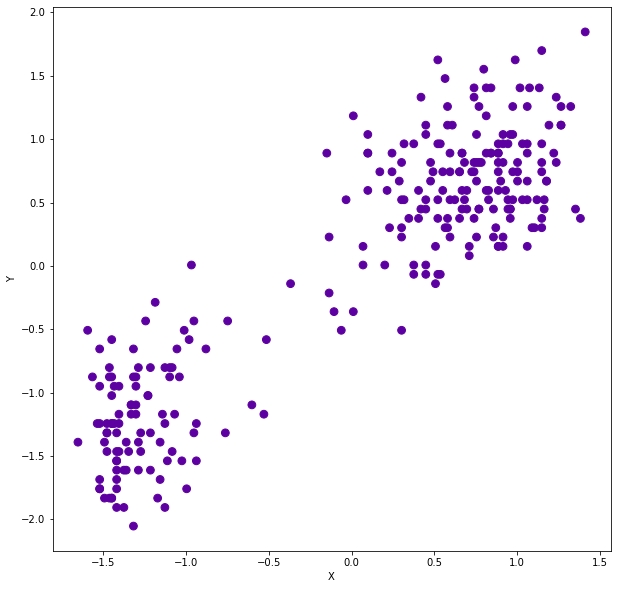

In [529]:
# plot the points with their RGB as a function of the probability of belonging to each cluster
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.values[:, 0], df.values[:, 1], c=colors, s=60)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

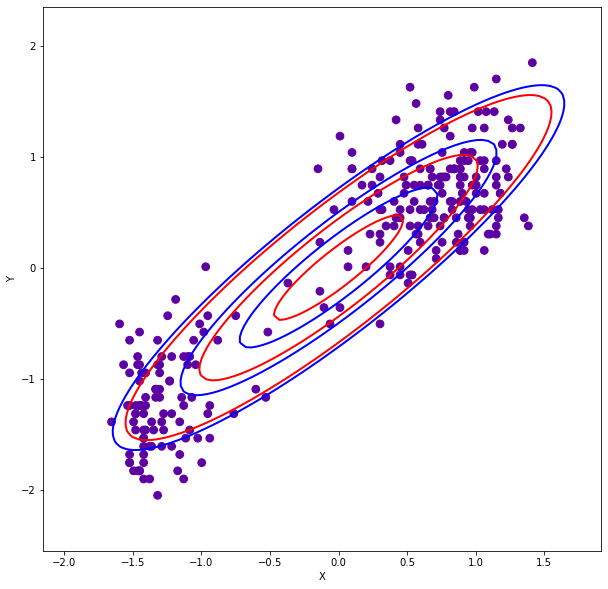

In [530]:
# plot the points with their RGB as a function of the probability of belonging to each cluster
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df.values[:, 0], df.values[:, 1], c=colors, s=60)
ax.set_xlabel('X')
ax.set_ylabel('Y')
# plot the countour of the gaussian
x = np.linspace(df.values[:, 0].min() - 0.5, df.values[:, 0].max() + 0.5, 100)
y = np.linspace(df.values[:, 1].min() - 0.5, df.values[:, 1].max() + 0.5, 100)
X, Y = np.meshgrid(x, y)
crs = ['r', 'b']
for k in range(em.K):
    mu = em.MuList[k]
    sigma = em.SigmaList[k]
    Z = [em.gaussian_pdf(np.array([x, y]), mu, sigma)*em.PiList[k] for x, y in zip(np.ravel(X), np.ravel(Y))]
    Z = np.reshape(Z, X.shape)
    ax.contour(X, Y, Z, levels=3, colors=crs[k], linewidths=[2])
plt.show()

Itr :  0
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


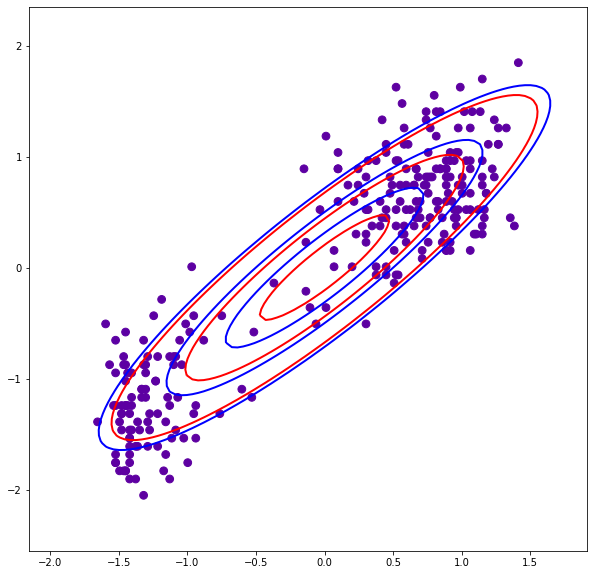

Itr :  1
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


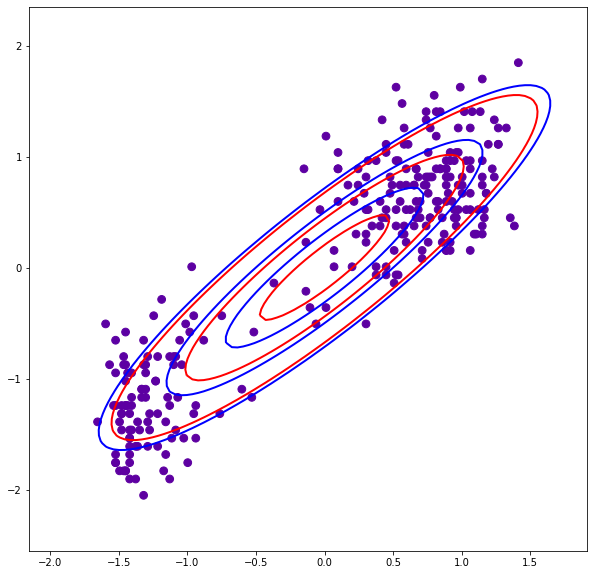

Itr :  2
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


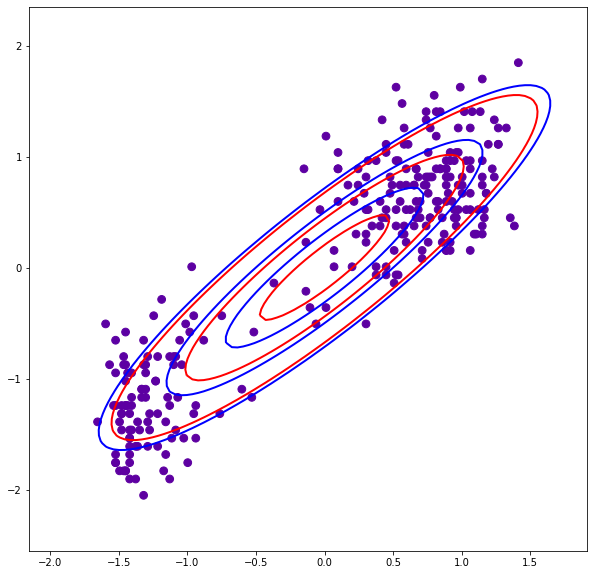

Itr :  3
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


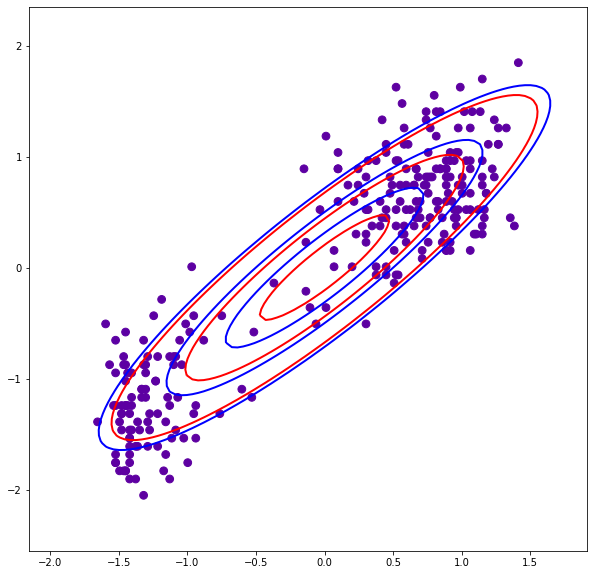

Itr :  4
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


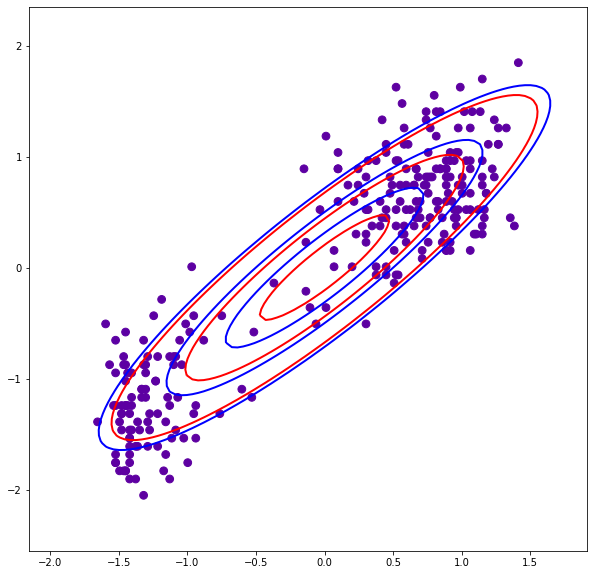

Itr :  5
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


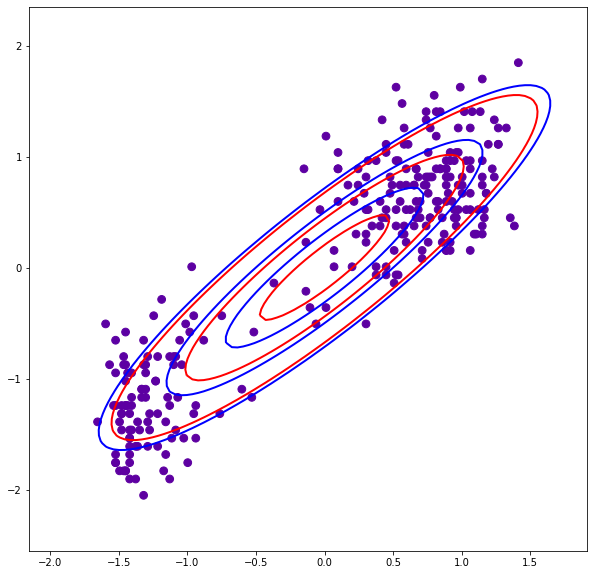

Itr :  6
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


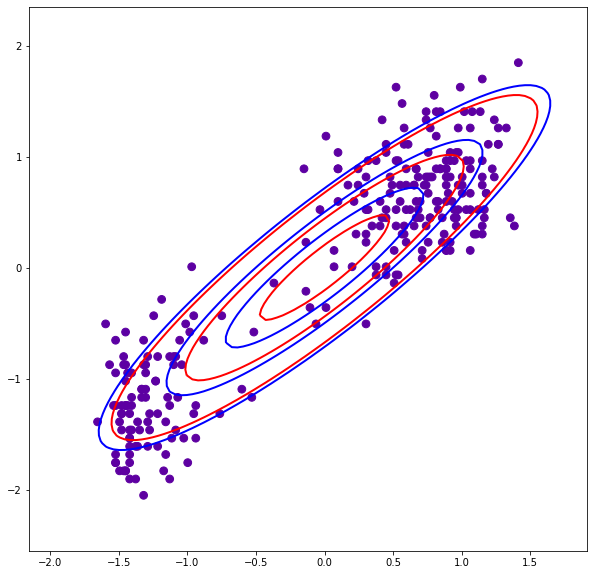

Itr :  7
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


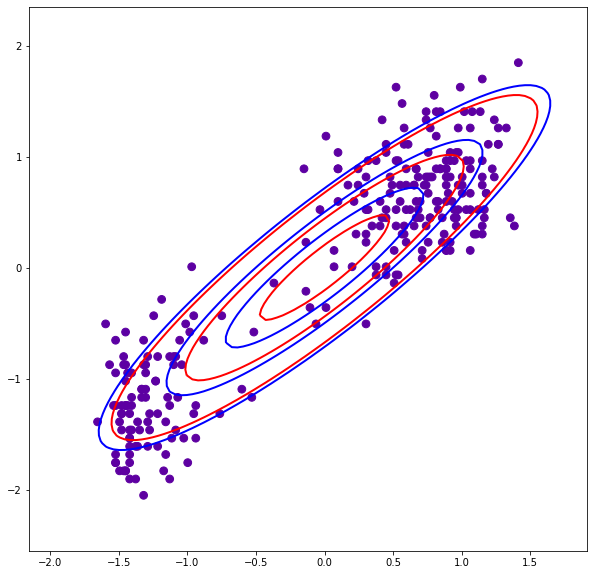

Itr :  8
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


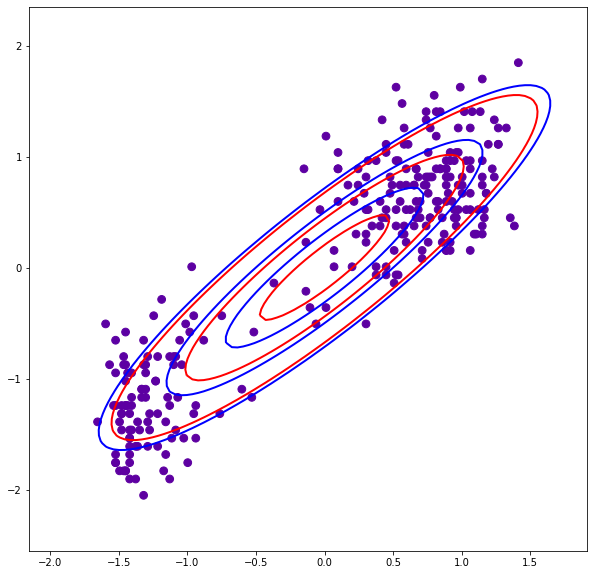

Itr :  9
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


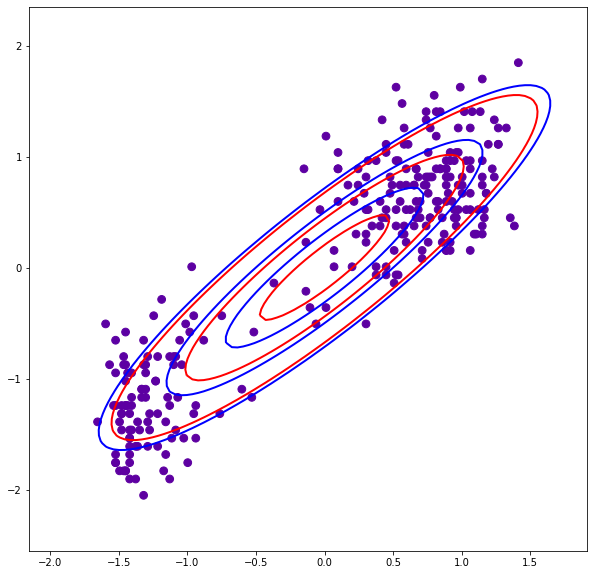

Itr :  10
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


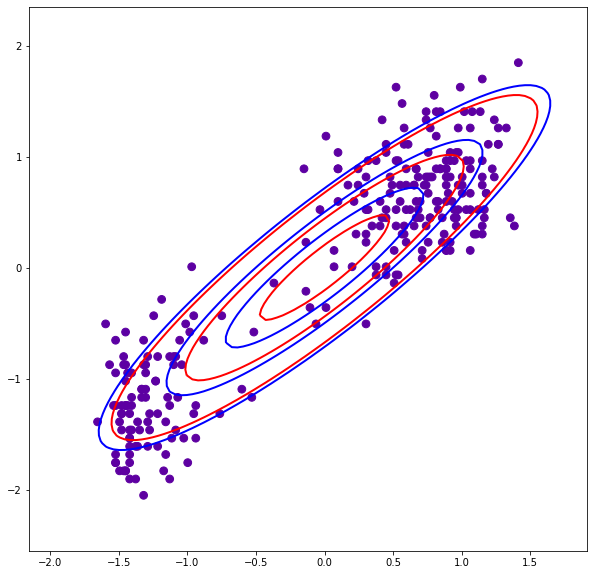

Itr :  11
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


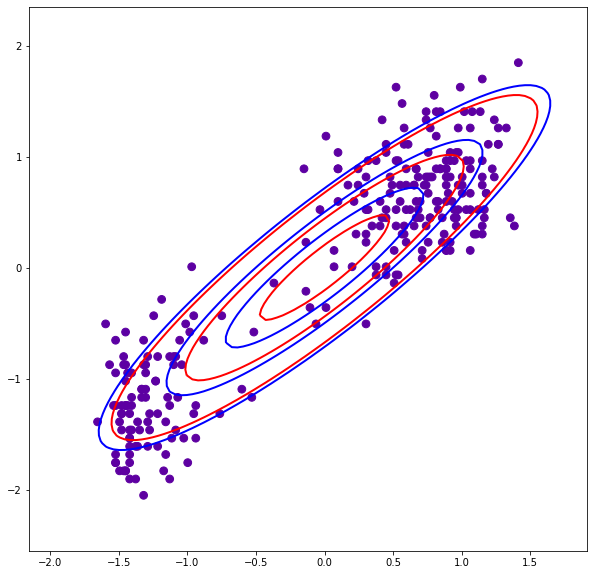

Itr :  12
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


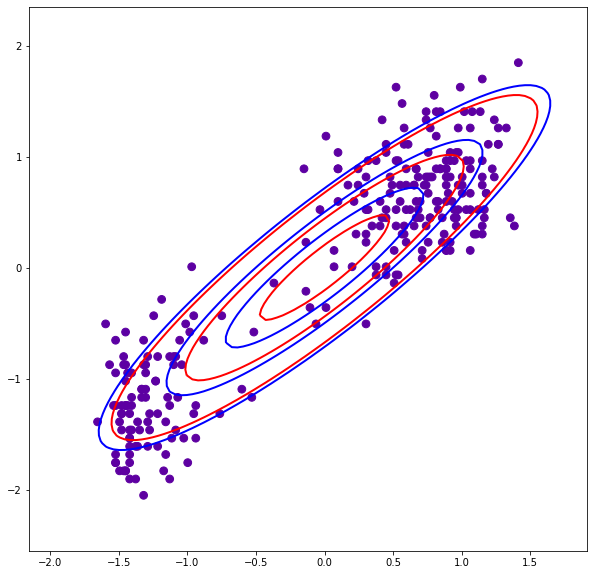

Itr :  13
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


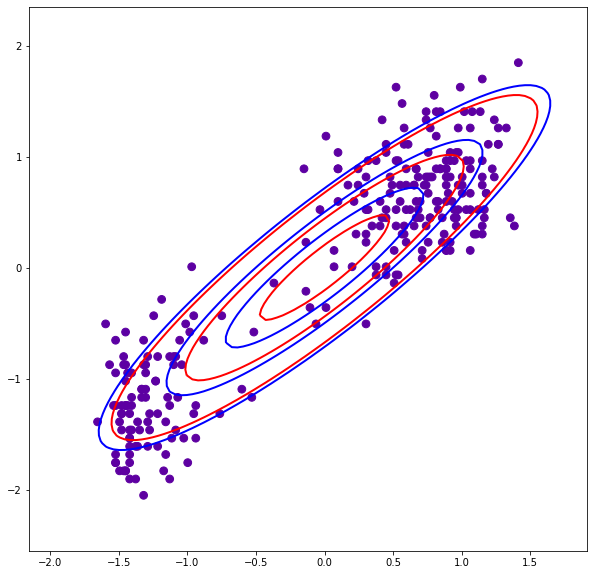

Itr :  14
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


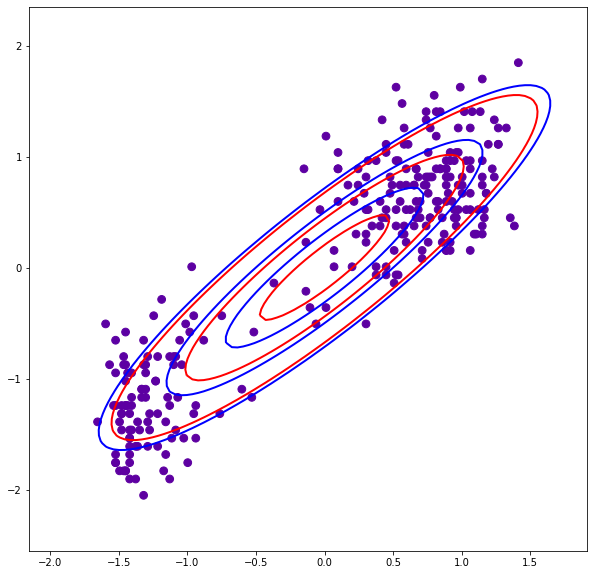

Itr :  15
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


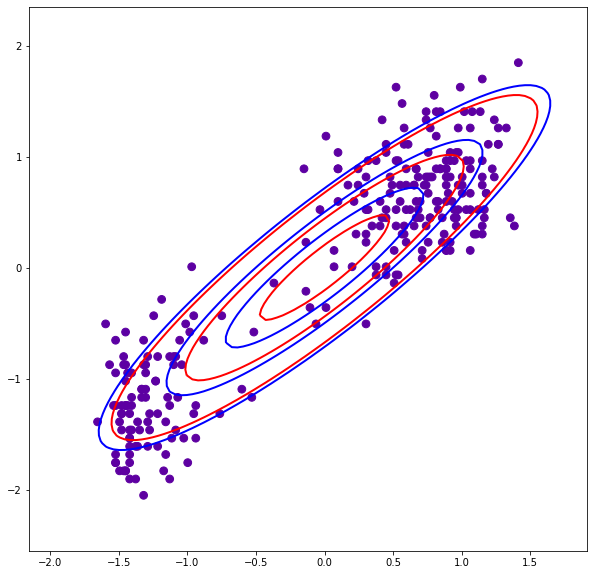

Itr :  16
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


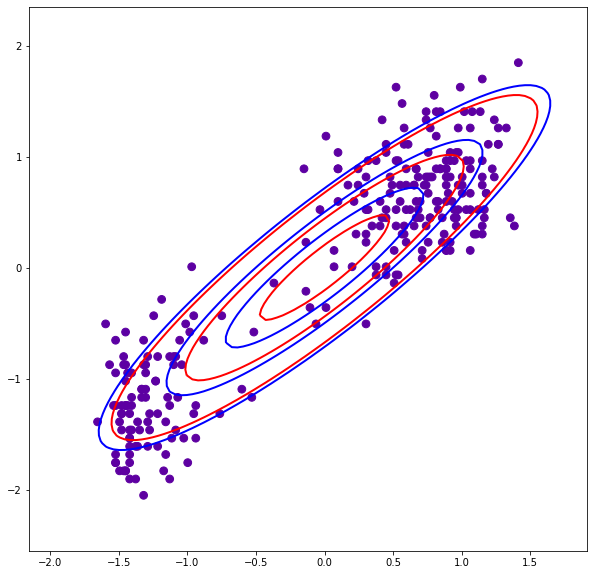

Itr :  17
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


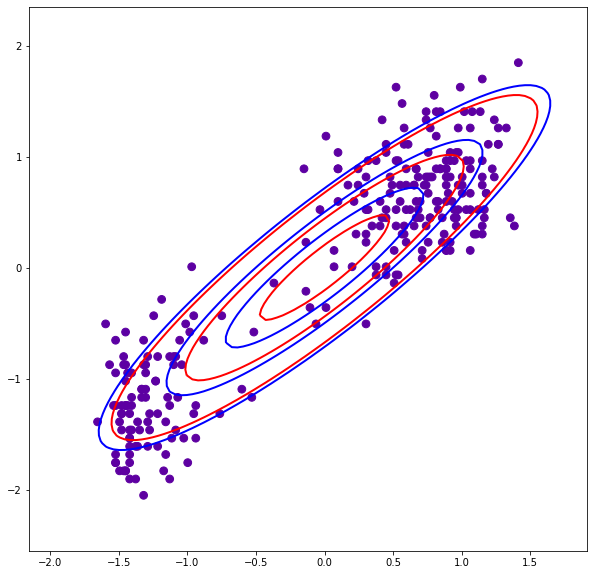

Itr :  18
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


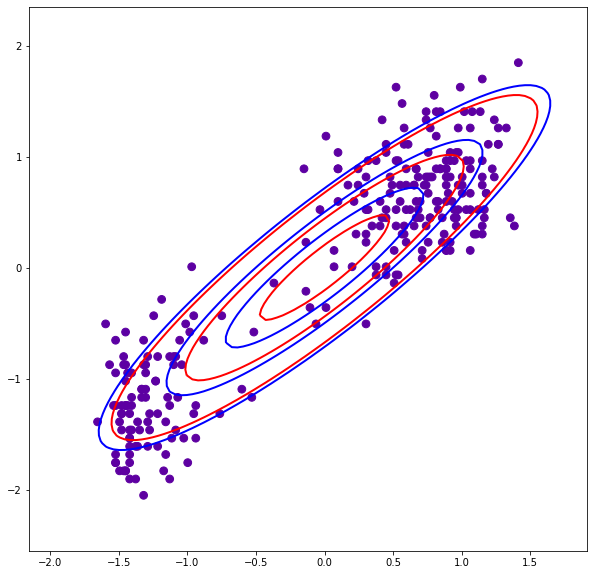

Itr :  19
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


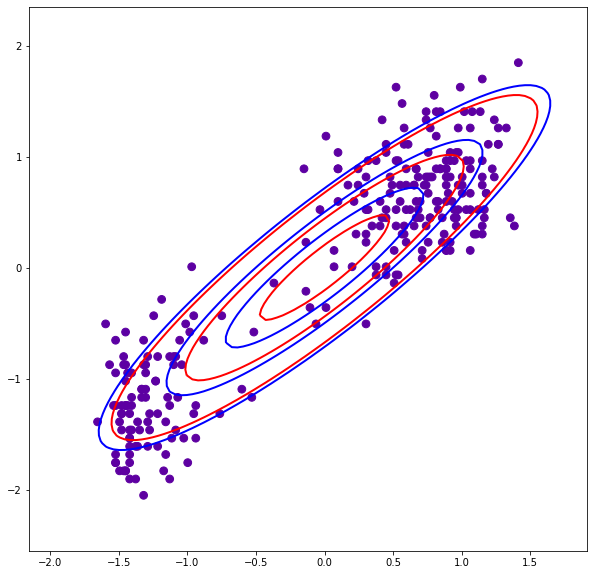

Itr :  20
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


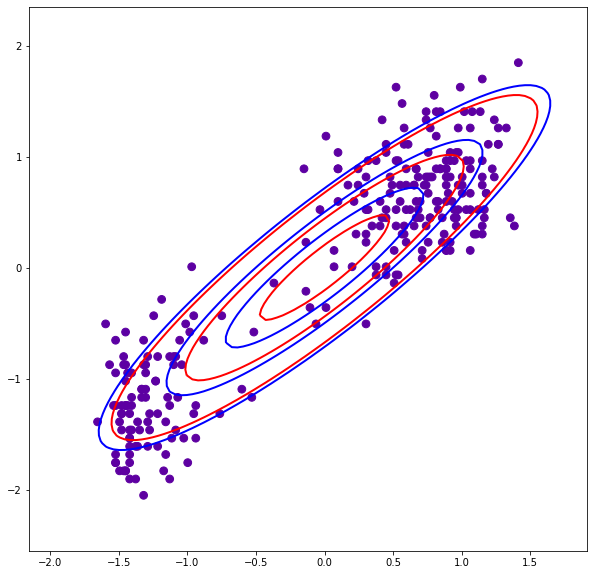

Itr :  21
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


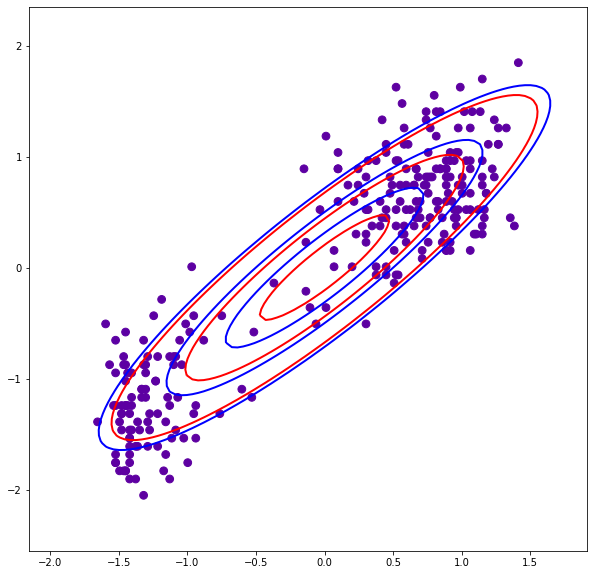

Itr :  22
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


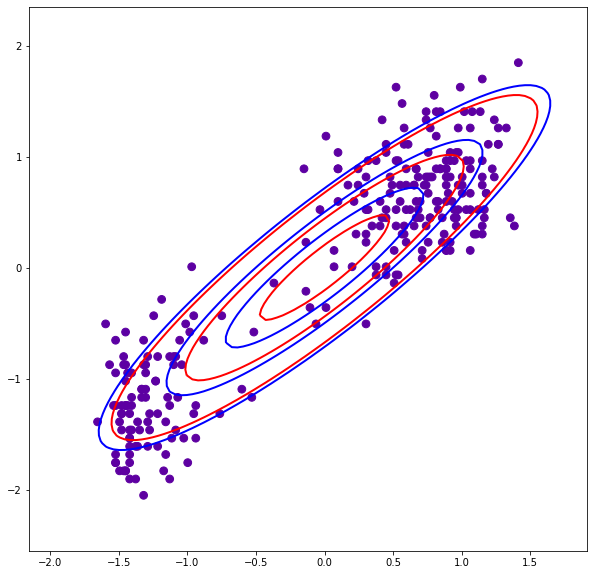

Itr :  23
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


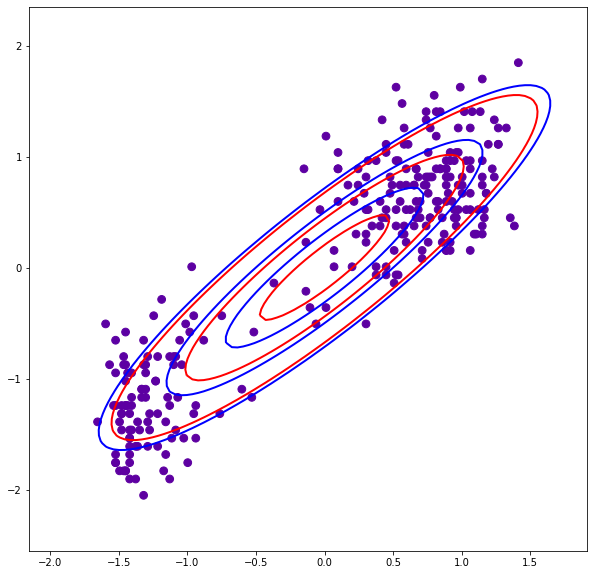

Itr :  24
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


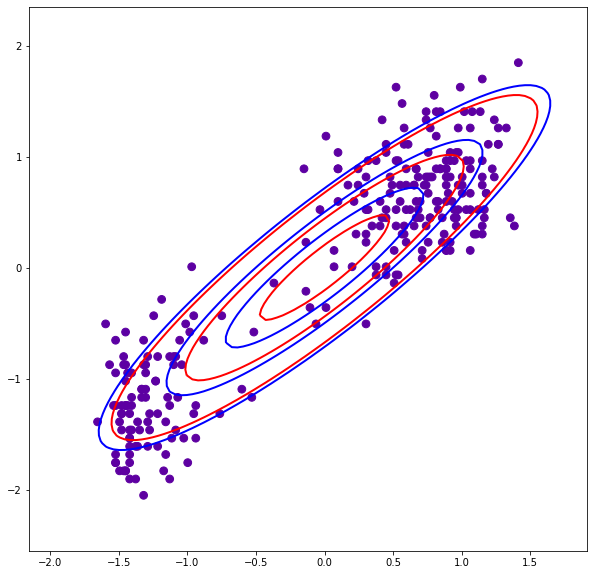

Itr :  25
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


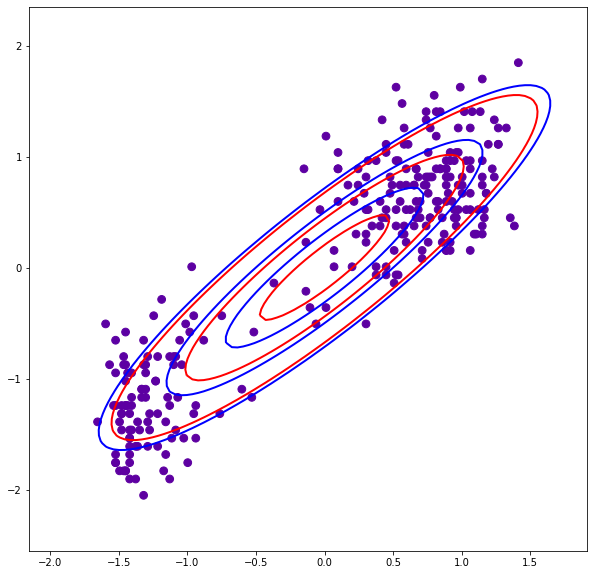

Itr :  26
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


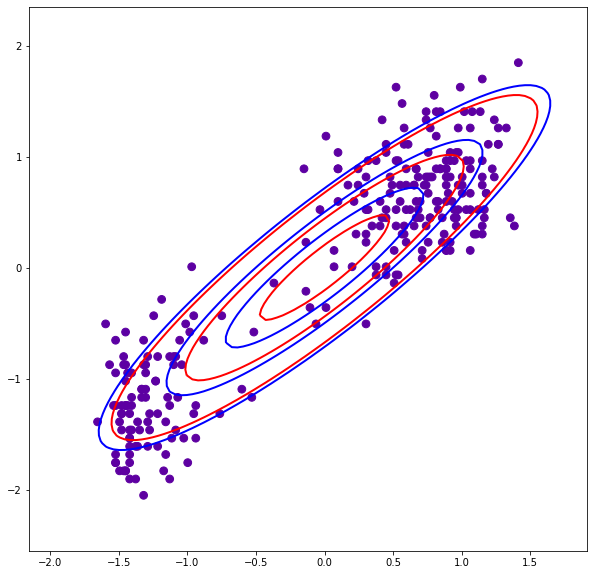

Itr :  27
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


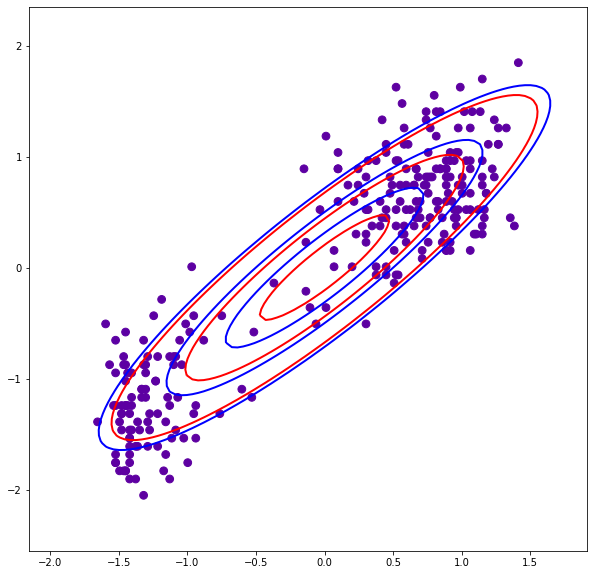

Itr :  28
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


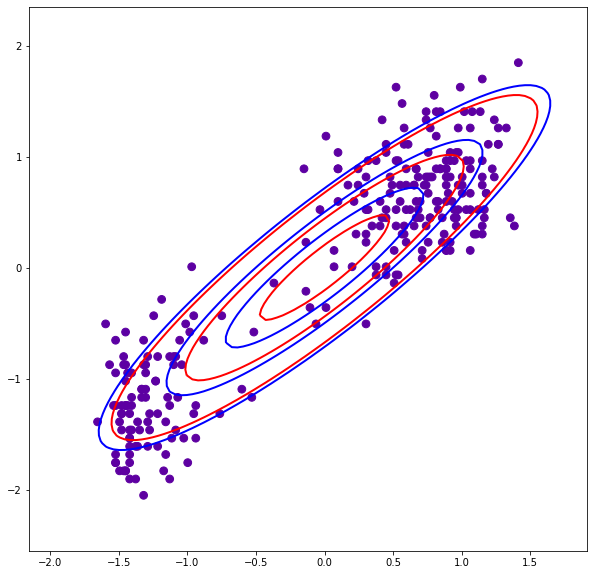

Itr :  29
[[0 0]
 [0 0]]
[[[0.99591558 0.89885015]
  [0.89885015 0.99931634]]

 [[0.99654272 0.89677359]
  [0.89677359 0.99471499]]]
[0.36490406 0.63509614]


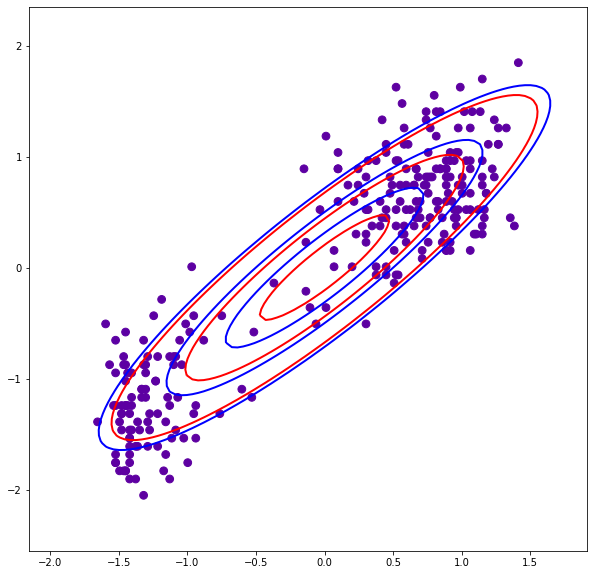

In [531]:
# plot the scatter subplots plot and countours for each iteration

iterationData = em.iterationData
for it in range(len(iterationData['MuList'])):
    fig, ax = plt.subplots(figsize=(10, 10))
    MuList = iterationData['MuList'][it]
    SigmaList = iterationData['SigmaList'][it]
    PiList = iterationData['PiList'][it]
    print("Itr : ", it)
    print(MuList)
    print(SigmaList)
    print(PiList)
    
    probabilities = np.zeros((df.shape[0], em.K))
    colors = np.zeros((df.shape[0], 3))
    for i in range(df.shape[0]):
        for k in range(em.K):
            probabilities[i, k] = PiList[k] * em.gaussian_pdf(df.values[i], MuList[k], SigmaList[k])
        # normalise probabilities
        probabilities[i] = probabilities[i] / np.sum(probabilities[i])
        # get color
        colors[i] = np.array([probabilities[i, 0], 0, probabilities[i, 1]])
    ax.scatter(df.values[:, 0], df.values[:, 1], c=colors, s=60)
    x = np.linspace(df.values[:, 0].min() - 0.5, df.values[:, 0].max() + 0.5, 100)
    y = np.linspace(df.values[:, 1].min() - 0.5, df.values[:, 1].max() + 0.5, 100)
    X, Y = np.meshgrid(x, y)
    crs = ['r', 'b']
    for k in range(em.K):
        mu = MuList[k]
        sigma = SigmaList[k]
        Z = [em.gaussian_pdf(np.array([x, y]), mu, sigma)*PiList[k] for x, y in zip(np.ravel(X), np.ravel(Y))]
        Z = np.reshape(Z, X.shape)
        ax.contour(X, Y, Z, levels=3, colors=crs[k], linewidths=[2])

    plt.show()
        


